# OpenRefine MCO2

This dataset mainly focuses on tides in Puerto Princesa, Palawan from 2017 to 2020. 
The information that will be included in this dataset are:
- date of record
- day of record
- sunrise time
- sunset time
- moonrise time
- moonset time
- moon distance from earth
- tide height
- tide time
- tide type
- tidal coefficient
- coefficient interpretation
- red tide occurrence in Honda bay and Puerto Princesa Bay

# Import of Packages

In [1]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import datetime
import time as time
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calplot

import os
from IPython.display import display

# Data Collection (NO NEED TO RUN)
The sites that were scraped are as follows:
- Tide Information:
    - https://tides4fishing.com/as/philippines/puerto-princesa#_tide_table
- Moon Rise and Set
    - http://moon.5deg.com/ph/puerto-princesa/
    
Information on the red tide occurrences were obtained from the red tide bulletin of the Philippine Burueau of Fisheries and Aquatic Resources and was manually encoded into a csv file.

## Tide Information
Information about the tides were obtained from Tides4Fishing. The site's content for historical data could not be accessed through changing the URL since the site was coded in such a way that the data is being accessed through a javascript within the site. Selenium was used to scrape the historical data.

Accessing the Tides4Fishing site and checking of page content

Finding and accessing the table where the desired data was scraped.

Trial of scraping of one month and temporarily placing the information obtained into a data frame.

Information can be accessed through the following indices:

|Index|Information|
|-----|-----------|
|  1  |Day of Month (1-31) and Day of Week (Sun, Mon, Tue, Wed, Thu, Fri, Sat)|
|  5  |Sunrise and Sunset Time (24-hour format)|
|  7  |1st Tide (Time and Height in m)|
|  9  |2nd Tide (Time and Height in m)|
| 11  |3rd Tide (Time and Height in m)|
| 13  |4th Tide (Time and Height in m)|
| 15  |Tidal Coefficient|


Complete scraping of all the data through Selenium and saving each month into a JSON file.

## Moonrise and Moonset

Accessing of Moon.5deg site. All tables with tableline as class within the HTML was obtained. Checking of index where the desired table of values was also inspected. Desired table is located at index 1.

The table below shows the index of the information from the desired table.

|Index|Information|
|-----|-----------|
|  1  |Day of Month (1-31)|
|  3  |Day of Week (Sunday, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday)|
|  5  |Moonrise Time (24-hour format)|
|  7  |Moonset Time (24-hour format)|
|  11 |Approximate Distance of Moon from Earth in km|

# Opening and Processing of JSON and CSV files to Dataframes

## Tides4Fishing Data

In [2]:
months = ['December','November','October','September','August', 'July', 'June','May', 'April', 'March', 'February','January']
months_num = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
twelvetracker = 0
filename = 't4f'
year = 2021
datalist = []
dataframelist = []

#Opening of monthly tide information JSON files (from December 2020 to January 2017) and appending them to datalist
for x in range(5, 53):
    filenum = str(x)
    with open('v2/t4f jsons/' + filename+ '-' + filenum+'.json', 'r') as openfile:
        t4f_json = json.load(openfile)
    datalist.append(t4f_json)
    
#Converting each JSON file to a dataframe
for k in range(48):
    dataframelist.append(pd.DataFrame.from_dict(datalist[k]))

#Processing and printing of dataframes
for i in dataframelist:
    if twelvetracker == 0:
        year = year - 1
        stryear = str(year)
    else:
        stryear = str(year)
    
#     print(months[twelvetracker] + " " + stryear)
    
    #Formatting days to date
    dates = []
    dayofWeek =[]
    
    tempDays = i['day'].str.split()
    
    for j in range(len(tempDays)):
        dayofMonth = tempDays[j][0]
        dayofWeek.append(tempDays[j][1])
        date = str(months_num[twelvetracker]) + '/' + dayofMonth + '/' + stryear
        dates.append(date)

    dates
    i["date"] = dates
    i['date'] = pd.to_datetime(i['date'])
    
    #Splitting time column to sunrise and sunset columns
    sunrise = []
    sunset = []

    for s in range(len(i['time'])):
        sunrise.append(i['time'].str.split()[s][0])
        sunset.append(i['time'].str.split()[s][2])

    i["sunrise"] = sunrise
    i["sunset"] = sunset
    
    #Removing units included in the entries
    for t in range(len(i["tidetime1"])):
        if (i["tidetime1"][t] != "no record"):
            i["tidetime1"][t] = i["tidetime1"][t].split()[0]
        if (i["tideheight1"][t] != "no record"):
            i["tideheight1"][t] = i["tideheight1"][t].split()[0]
        if (i["tidetime2"][t] != "no record"):
            i["tidetime2"][t] = i["tidetime2"][t].split()[0]
        if (i["tideheight2"][t] != "no record"):
            i["tideheight2"][t] = i["tideheight2"][t].split()[0]
        if (i["tidetime3"][t] != "no record"):
            i["tidetime3"][t] = i["tidetime3"][t].split()[0]
        if (i["tideheight3"][t] != "no record"):
            i["tideheight3"][t] = i["tideheight3"][t].split()[0]
        if (i["tidetime4"][t] != "no record"):
            i["tidetime4"][t] = i["tidetime4"][t].split()[0]
        if (i["tideheight4"][t] != "no record"):
            i["tideheight4"][t] = i["tideheight4"][t].split()[0]
    
    #Splitting the coefficient column to coefficient and coeff_interpretation columns
    coefficient = []
    coeff_interpretation = []

    for c in range(len(i['coefficient'])):
        coefficient.append(i['coefficient'].str.split()[c][0])
        coeff_interpretation.append(i['coefficient'].str.split()[c][1])

    i["coefficient"] = coefficient
    i["coeff_interpretation"] = coeff_interpretation
    
    #Display the datarframes
#     display(i)
#     print('\n')
    
    #This is to track and update the month
    twelvetracker = twelvetracker + 1
    if twelvetracker > 11:
        twelvetracker = 0

<ipython-input-2-9c0c14645132>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i["tidetime1"][t] = i["tidetime1"][t].split()[0]
<ipython-input-2-9c0c14645132>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i["tideheight1"][t] = i["tideheight1"][t].split()[0]
<ipython-input-2-9c0c14645132>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i["tidetime2"][t] = i["tidetime2"][t].split()[0]
<ipython-input-2-9c0c14645132>:66: SettingWit

Dropping the repetitive columns that were already split.

In [3]:
tidesdf = dataframelist[0]

for i in range(1, len(dataframelist)):
    tidesdf = tidesdf.append(dataframelist[i])
    
tidesdf.drop('day', inplace = True, axis=1)
tidesdf.drop('time', inplace = True, axis=1)

In [4]:
tidesdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 30
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tidetime1             1461 non-null   object        
 1   tideheight1           1461 non-null   object        
 2   tidetime2             1461 non-null   object        
 3   tideheight2           1461 non-null   object        
 4   tidetime3             1461 non-null   object        
 5   tideheight3           1461 non-null   object        
 6   tidetime4             1461 non-null   object        
 7   tideheight4           1461 non-null   object        
 8   coefficient           1461 non-null   object        
 9   date                  1461 non-null   datetime64[ns]
 10  sunrise               1461 non-null   object        
 11  sunset                1461 non-null   object        
 12  coeff_interpretation  1461 non-null   object        
dtypes: datetime64[ns](1)

In [5]:
tidesdf

,tidetime1,tideheight1,tidetime2,tideheight2,tidetime3,tideheight3,tidetime4,tideheight4,coefficient,date,sunrise,sunset,coeff_interpretation
0,5:54,-0.1,13:15,0.7,14:09,0.4,22:17,1.4,77,2020-12-01,6:06,17:42,high
1,6:36,-0.2,22:46,1.4,no record,no record,no record,no record,74,2020-12-02,6:06,17:43,high
2,7:20,-0.2,23:18,1.4,no record,no record,no record,no record,69,2020-12-03,6:07,17:43,average
3,8:08,-0.2,23:53,1.4,no record,no record,no record,no record,62,2020-12-04,6:07,17:43,average
4,8:59,-0.2,no record,no record,no record,no record,no record,no record,56,2020-12-05,6:08,17:43,average
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,5:30,-0.2,21:47,1.3,no record,no record,no record,no record,85,2017-01-27,6:27,18:09,high
27,6:03,-0.2,13:03,0.5,14:06,0.2,22:25,1.4,89,2017-01-28,6:27,18:09,high
28,6:36,-0.2,13:21,0.5,15:04,0.2,23:02,1.3,92,2017-01-29,6:27,18:09,very
29,7:06,-0.2,13:43,0.6,15:59,0.2,23:40,1.3,90,2017-01-30,6:27,18:10,very


## Moon Data

Opening the Moon Data

In [6]:
moonframe = pd.read_json('moon.json')

In [7]:
moonframe

,date,day,moonrise,moonset,distance
0,2017-01-01,Sunday,08:29,20:31,387620
1,2017-01-02,Monday,09:16,21:23,382892
2,2017-01-03,Tuesday,10:02,22:14,378186
3,2017-01-04,Wednesday,10:48,23:06,373755
4,2017-01-05,Thursday,11:34,23:59,369848
...,...,...,...,...,...
1456,2020-12-27,Sunday,15:36,03:39,403274
1457,2020-12-28,Monday,16:22,04:29,400801
1458,2020-12-29,Tuesday,17:12,05:21,397535
1459,2020-12-30,Wednesday,18:05,06:14,393608


## Red Tide Data

Opening the Red Tide Data

In [8]:
redtideFrame = pd.read_csv('RedTide.csv')

Transforming `date` column from object to datetime format since the `date` column is not yet in datetime format.

In [9]:
redtideFrame['date'] = pd.to_datetime(redtideFrame['date'])

In [10]:
redtideFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           1462 non-null   datetime64[ns]
 1   redtide_pp     1462 non-null   int64         
 2   redtide_honda  1462 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 34.4 KB


In [11]:
redtideFrame

,date,redtide_pp,redtide_honda
0,2016-12-31,0,0
1,2017-01-01,0,0
2,2017-01-02,0,0
3,2017-01-03,0,0
4,2017-01-04,0,0
...,...,...,...
1457,2020-12-27,1,1
1458,2020-12-28,1,1
1459,2020-12-29,1,1
1460,2020-12-30,1,1


# Data Merging

Merging of Moon dataframe with Red Tide dataframe through left join using `date` of Moon as key to the final dataframe.

In [12]:
finalDF = moonframe.merge(redtideFrame, how = 'left', on = 'date')

Merging of final dataframe with tide information dataframe through left join using `date` of final dataframe as key.

In [13]:
finalDF = finalDF.merge(tidesdf, how = 'left', on = 'date')

Rearranging the columns of the final dataframe.

In [14]:
finalDF = finalDF[['date', 'day', 'sunrise', 'sunset', 'moonrise', 'moonset', 'distance','tidetime1','tideheight1','tidetime2','tideheight2','tidetime3','tideheight3','tidetime4','tideheight4','coefficient','coeff_interpretation','redtide_pp','redtide_honda']]

In [15]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   object        
 3   sunset                1461 non-null   object        
 4   moonrise              1461 non-null   object        
 5   moonset               1461 non-null   object        
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   object        
 8   tideheight1           1461 non-null   object        
 9   tidetime2             1461 non-null   object        
 10  tideheight2           1461 non-null   object        
 11  tidetime3             1461 non-null   object        
 12  tideheight3           1461 non-null   object        
 13  tidetime4         

In [16]:
finalDF

,date,day,sunrise,sunset,moonrise,moonset,distance,tidetime1,tideheight1,tidetime2,tideheight2,tidetime3,tideheight3,tidetime4,tideheight4,coefficient,coeff_interpretation,redtide_pp,redtide_honda
0,2017-01-01,Sunday,6:21,17:56,08:29,20:31,387620,7:44,-0.2,23:44,1.4,no record,no record,no record,no record,78,high,0,0
1,2017-01-02,Monday,6:22,17:57,09:16,21:23,382892,8:12,-0.2,no record,no record,no record,no record,no record,no record,73,high,0,0
2,2017-01-03,Tuesday,6:22,17:57,10:02,22:14,378186,0:20,1.3,8:47,-0.2,no record,no record,no record,no record,68,average,0,0
3,2017-01-04,Wednesday,6:23,17:58,10:48,23:06,373755,0:58,1.2,9:20,-0.1,no record,no record,no record,no record,62,average,0,0
4,2017-01-05,Thursday,6:23,17:58,11:34,23:59,369848,1:40,1.1,9:50,0.0,17:30,0.7,20:17,0.4,58,average,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,Sunday,6:19,17:53,15:36,03:39,403274,3:51,0.0,10:10,0.6,12:25,0.3,20:20,1.2,67,average,1,1
1457,2020-12-28,Monday,6:20,17:54,16:22,04:29,400801,4:34,-0.1,20:51,1.3,no record,no record,no record,no record,72,high,1,1
1458,2020-12-29,Tuesday,6:20,17:54,17:12,05:21,397535,5:14,-0.2,21:24,1.4,no record,no record,no record,no record,76,high,1,1
1459,2020-12-30,Wednesday,6:21,17:55,18:05,06:14,393608,5:54,-0.2,21:59,1.4,no record,no record,no record,no record,78,high,1,1


# Further Data Processing

Converting the datatype of coefficient and tide heights from object to its most appropriate numeric datatypes. No records were translated as null using `errors='coerce'`.

In [17]:
finalDF['coefficient'] = pd.to_numeric(finalDF['coefficient'], errors = 'coerce')
finalDF['tideheight1'] = pd.to_numeric(finalDF['tideheight1'], errors = 'coerce')
finalDF['tideheight2'] = pd.to_numeric(finalDF['tideheight2'], errors = 'coerce')
finalDF['tideheight3'] = pd.to_numeric(finalDF['tideheight3'], errors = 'coerce')
finalDF['tideheight4'] = pd.to_numeric(finalDF['tideheight4'], errors = 'coerce')

Converting the datatype of sunrise, sunset, moonrise, and moonset times from object to datetime format.

In [18]:
#Concatenating the corresponding date of the entry with the time of whatever it represents
for i in range(len(finalDF['sunrise'])):
    # sunrise time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['sunrise'][i]
    time = pd.to_datetime(time)
    finalDF['sunrise'][i] = time
    # sunset time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['sunset'][i]
    time = pd.to_datetime(time)
    finalDF['sunset'][i] = time
    # moonrise time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['moonrise'][i]
    time = pd.to_datetime(time)
    finalDF['moonrise'][i] = time
    # moonset time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['moonset'][i]
    time = pd.to_datetime(time)
    finalDF['moonset'][i] = time
    
#Conversion proper
finalDF['sunrise'] =pd.to_datetime(finalDF['sunrise'])
finalDF['sunset'] =pd.to_datetime(finalDF['sunset'])
finalDF['moonrise'] =pd.to_datetime(finalDF['moonrise'])
finalDF['moonset'] =pd.to_datetime(finalDF['moonset'])

<ipython-input-18-d9604eb6a25a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['sunrise'][i] = time
<ipython-input-18-d9604eb6a25a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['sunset'][i] = time
<ipython-input-18-d9604eb6a25a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['moonrise'][i] = time
<ipython-input-18-d9604eb6a25a>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

In [19]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   datetime64[ns]
 3   sunset                1461 non-null   datetime64[ns]
 4   moonrise              1461 non-null   datetime64[ns]
 5   moonset               1461 non-null   datetime64[ns]
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   object        
 8   tideheight1           1461 non-null   float64       
 9   tidetime2             1461 non-null   object        
 10  tideheight2           1411 non-null   float64       
 11  tidetime3             1461 non-null   object        
 12  tideheight3           811 non-null    float64       
 13  tidetime4         

Converting the datatype of tide times from object to datetime format.

In [20]:
#Concatenating and converting
for i in range(len(finalDF['tidetime1'])):
    # tide 1 time conversion to datetime data type
    time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime1'][i]
    time = pd.to_datetime(time)
    finalDF['tidetime1'][i] = time
    # tide 2 time conversion to datetime data type
    if (finalDF['tidetime2'][i] != "no record"):
        time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime2'][i]
        time = pd.to_datetime(time)
        finalDF['tidetime2'][i] = time
    # tide 3 time conversion to datetime data type
    if (finalDF['tidetime3'][i] != "no record"):
        time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime3'][i]
        time = pd.to_datetime(time)
        finalDF['tidetime3'][i] = time
    # tide 4 time conversion to datetime data type
    if (finalDF['tidetime4'][i] != "no record"):
        time = str(finalDF['date'][i]).split()[0] + " " + finalDF['tidetime4'][i]
        time = pd.to_datetime(time)
        finalDF['tidetime4'][i] = time
        
#To fill in no records with NaT
finalDF['tidetime1'] = pd.to_datetime(finalDF['tidetime1'], errors='coerce')
finalDF['tidetime2'] = pd.to_datetime(finalDF['tidetime2'], errors='coerce')
finalDF['tidetime3'] = pd.to_datetime(finalDF['tidetime3'], errors='coerce')
finalDF['tidetime4'] = pd.to_datetime(finalDF['tidetime4'], errors='coerce')

<ipython-input-20-843d2dc4cee3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetime1'][i] = time
<ipython-input-20-843d2dc4cee3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetime2'][i] = time
<ipython-input-20-843d2dc4cee3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetime3'][i] = time
<ipython-input-20-843d2dc4cee3>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [21]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   datetime64[ns]
 3   sunset                1461 non-null   datetime64[ns]
 4   moonrise              1461 non-null   datetime64[ns]
 5   moonset               1461 non-null   datetime64[ns]
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   datetime64[ns]
 8   tideheight1           1461 non-null   float64       
 9   tidetime2             1411 non-null   datetime64[ns]
 10  tideheight2           1411 non-null   float64       
 11  tidetime3             811 non-null    datetime64[ns]
 12  tideheight3           811 non-null    float64       
 13  tidetime4         

Getting the tide type (high or low tide) based on the given tide heights. 

In [22]:
tidetype1 = []
tidetype2 = []
tidetype3 = []
tidetype4 = []

#Populating the arrays with placeholders
for i in range(len(finalDF['date'])):
    tidetype1.append('-')
    tidetype2.append('-')
    tidetype3.append('-')
    tidetype4.append('-')

#Placing information of the arrays into columns in the final dataframe
finalDF['tidetype1'] = tidetype1
finalDF['tidetype2'] = tidetype2
finalDF['tidetype3'] = tidetype3
finalDF['tidetype4'] = tidetype4

#Replacing the placeholders with actual values (tide type)
# 0 = no record, -1 = low, 1 = high
for i in range(len(finalDF['date'])):
    #If only one tide was recorded for the day
    if(pd.notnull(finalDF['tideheight1'][i]) and pd.isnull(finalDF['tideheight2'][i])):
        if(finalDF['tideheight1'][i] > 0):
            finalDF['tidetype1'][i] = 1
            finalDF['tidetype2'][i] = 0
            finalDF['tidetype3'][i] = 0
            finalDF['tidetype4'][i] = 0
        elif(finalDF['tideheight1'][i] <= 0):
            finalDF['tidetype1'][i] = -1
            finalDF['tidetype2'][i] = 0
            finalDF['tidetype3'][i] = 0
            finalDF['tidetype4'][i] = 0
    #If two or more tides were recorded for the day
    elif(pd.notnull(finalDF['tideheight1'][i]) and pd.notnull(finalDF['tideheight2'][i])):
        if(finalDF['tideheight1'][i] > finalDF['tideheight2'][i]):
            finalDF['tidetype1'][i] = 1
            finalDF['tidetype2'][i] = -1
            if(pd.notnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = 1
                if(pd.notnull(finalDF['tideheight4'][i])):
                    finalDF['tidetype4'][i] = -1
                elif(pd.isnull(finalDF['tideheight4'][i])):
                    finalDF['tideheight4'][i] = 0
            elif(pd.isnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = 0
                finalDF['tidetype4'][i] = 0
        elif(finalDF['tideheight1'][i] < finalDF['tideheight2'][i]):
            finalDF['tidetype1'][i] = -1
            finalDF['tidetype2'][i] = 1
            if(pd.notnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = -1
                if(pd.notnull(finalDF['tideheight4'][i])):
                    finalDF['tidetype4'][i] = 1
                elif(pd.isnull(finalDF['tideheight4'][i])):
                    finalDF['tideheight4'][i] = 0
            elif(pd.isnull(finalDF['tideheight3'][i])):
                finalDF['tidetype3'][i] = 0
                finalDF['tidetype4'][i] = 0

<ipython-input-22-fd88d118c285>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetype1'][i] = -1
<ipython-input-22-fd88d118c285>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetype2'][i] = 1
<ipython-input-22-fd88d118c285>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['tidetype3'][i] = 0
<ipython-input-22-fd88d118c285>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [23]:
finalDF = finalDF[['date', 'day', 'sunrise', 'sunset', 'moonrise', 'moonset', 'distance','tidetime1','tideheight1','tidetype1','tidetime2','tideheight2','tidetype2','tidetime3','tideheight3','tidetype3','tidetime4','tideheight4','tidetype4','coefficient','coeff_interpretation','redtide_pp','redtide_honda']]

In [24]:
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1461 entries, 0 to 1460
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  1461 non-null   datetime64[ns]
 1   day                   1461 non-null   object        
 2   sunrise               1461 non-null   datetime64[ns]
 3   sunset                1461 non-null   datetime64[ns]
 4   moonrise              1461 non-null   datetime64[ns]
 5   moonset               1461 non-null   datetime64[ns]
 6   distance              1461 non-null   int64         
 7   tidetime1             1461 non-null   datetime64[ns]
 8   tideheight1           1461 non-null   float64       
 9   tidetype1             1461 non-null   object        
 10  tidetime2             1411 non-null   datetime64[ns]
 11  tideheight2           1411 non-null   float64       
 12  tidetype2             1461 non-null   object        
 13  tidetime3         

In [25]:
finalDF

,date,day,sunrise,sunset,moonrise,moonset,distance,tidetime1,tideheight1,tidetype1,...,tidetime3,tideheight3,tidetype3,tidetime4,tideheight4,tidetype4,coefficient,coeff_interpretation,redtide_pp,redtide_honda
0,2017-01-01,Sunday,2017-01-01 06:21:00,2017-01-01 17:56:00,2017-01-01 08:29:00,2017-01-01 20:31:00,387620,2017-01-01 07:44:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,78,high,0,0
1,2017-01-02,Monday,2017-01-02 06:22:00,2017-01-02 17:57:00,2017-01-02 09:16:00,2017-01-02 21:23:00,382892,2017-01-02 08:12:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,73,high,0,0
2,2017-01-03,Tuesday,2017-01-03 06:22:00,2017-01-03 17:57:00,2017-01-03 10:02:00,2017-01-03 22:14:00,378186,2017-01-03 00:20:00,1.3,1,...,NaT,NaN,0,NaT,NaN,0,68,average,0,0
3,2017-01-04,Wednesday,2017-01-04 06:23:00,2017-01-04 17:58:00,2017-01-04 10:48:00,2017-01-04 23:06:00,373755,2017-01-04 00:58:00,1.2,1,...,NaT,NaN,0,NaT,NaN,0,62,average,0,0
4,2017-01-05,Thursday,2017-01-05 06:23:00,2017-01-05 17:58:00,2017-01-05 11:34:00,2017-01-05 23:59:00,369848,2017-01-05 01:40:00,1.1,1,...,2017-01-05 17:30:00,0.7,1,2017-01-05 20:17:00,0.4,-1,58,average,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,Sunday,2020-12-27 06:19:00,2020-12-27 17:53:00,2020-12-27 15:36:00,2020-12-27 03:39:00,403274,2020-12-27 03:51:00,0.0,-1,...,2020-12-27 12:25:00,0.3,-1,2020-12-27 20:20:00,1.2,1,67,average,1,1
1457,2020-12-28,Monday,2020-12-28 06:20:00,2020-12-28 17:54:00,2020-12-28 16:22:00,2020-12-28 04:29:00,400801,2020-12-28 04:34:00,-0.1,-1,...,NaT,NaN,0,NaT,NaN,0,72,high,1,1
1458,2020-12-29,Tuesday,2020-12-29 06:20:00,2020-12-29 17:54:00,2020-12-29 17:12:00,2020-12-29 05:21:00,397535,2020-12-29 05:14:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,76,high,1,1
1459,2020-12-30,Wednesday,2020-12-30 06:21:00,2020-12-30 17:55:00,2020-12-30 18:05:00,2020-12-30 06:14:00,393608,2020-12-30 05:54:00,-0.2,-1,...,NaT,NaN,0,NaT,NaN,0,78,high,1,1


In [26]:
finalDF.to_csv('finalDF.csv', index=False)
finalDF.to_json(r'finalDF.json')

# EDA

## (Inferential) What time of the day and/or day of the month and/or month of the year would be best for fishing? 



In [27]:
#Creating a function that can convert the Coefficient Interpretation into numerical values.
def coeffConverter(checker):
    if(checker == 'high'):
        return 2
    elif(checker == 'average'):
        return 1
    else:
        return 0

#If you want to show high tides only
#def coeffConverter(checker):
#    if(checker == 'high'):
#        return 1
#    else:
#        return 1

In [28]:
#Creates a new dataframe with only the necessary columns, as well as the new column that converts coeff_interpretation in to numerical values.
fishDF = finalDF[["date", "coeff_interpretation"]].copy()
fishDF['coeff_val'] = fishDF['coeff_interpretation'].apply(coeffConverter)
fishDF

,date,coeff_interpretation,coeff_val
0,2017-01-01,high,2
1,2017-01-02,high,2
2,2017-01-03,average,1
3,2017-01-04,average,1
4,2017-01-05,average,1
...,...,...,...
1456,2020-12-27,average,1
1457,2020-12-28,high,2
1458,2020-12-29,high,2
1459,2020-12-30,high,2


### Calendar Heatmap on Tidal Coefficients

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


(<Figure size 900x489.6 with 5 Axes>,
 array([<AxesSubplot:ylabel='2017'>, <AxesSubplot:ylabel='2018'>,
        <AxesSubplot:ylabel='2019'>, <AxesSubplot:ylabel='2020'>],
       dtype=object))

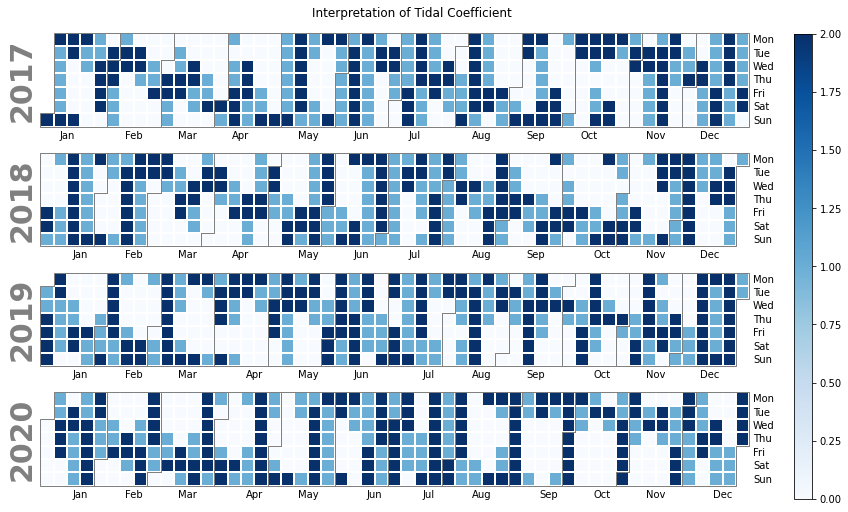

In [29]:
#Creating a calendar heat map on the which days of the year are high, average, and low Tidal Coefficient.
fishDF = fishDF.set_index("date") # must be run only once

calplot.calplot(fishDF["coeff_val"], suptitle="Interpretation of Tidal Coefficient", cmap="Blues", colorbar=True)

It is said that fishing is better during days with high tidal coefficients as these affect the movement of the fishes from the currents caused by the changes in tides. Dark blue denotes high tidal coefficient. Sky blue denotes average tidal coefficient. White denotes low tidal coefficient.
From the graph, although there is some kind of observable pattern that can be discerned to determine the best time to fish, it is still quite unpredictable. But from what we can gather is that the months are divided into three, where each third represents a cycle. Each cycle starts with high tidal coefficients on a certain day of a week then moves towards the end of the week at the end of each cycle.

## (Inferential) What are months of the year that the area is prone to red tide? 

In [30]:
#Creating a new array that will be used as a column; holds the month of the date column.
month = []
for i in range(len(finalDF['date'])):
    month.append(finalDF['date'][i].month)

In [31]:
#Creating a new array that will be used as a column, holds the year of the date column.
year = []
for i in range(len(finalDF['date'])):
        year.append(finalDF['date'][i].year)

In [32]:
#Adding the two new columns into the dataframe 
EDADF = finalDF.copy()
EDADF['month'] = month
EDADF['year'] = year
EDADF

,date,day,sunrise,sunset,moonrise,moonset,distance,tidetime1,tideheight1,tidetype1,...,tidetype3,tidetime4,tideheight4,tidetype4,coefficient,coeff_interpretation,redtide_pp,redtide_honda,month,year
0,2017-01-01,Sunday,2017-01-01 06:21:00,2017-01-01 17:56:00,2017-01-01 08:29:00,2017-01-01 20:31:00,387620,2017-01-01 07:44:00,-0.2,-1,...,0,NaT,NaN,0,78,high,0,0,1,2017
1,2017-01-02,Monday,2017-01-02 06:22:00,2017-01-02 17:57:00,2017-01-02 09:16:00,2017-01-02 21:23:00,382892,2017-01-02 08:12:00,-0.2,-1,...,0,NaT,NaN,0,73,high,0,0,1,2017
2,2017-01-03,Tuesday,2017-01-03 06:22:00,2017-01-03 17:57:00,2017-01-03 10:02:00,2017-01-03 22:14:00,378186,2017-01-03 00:20:00,1.3,1,...,0,NaT,NaN,0,68,average,0,0,1,2017
3,2017-01-04,Wednesday,2017-01-04 06:23:00,2017-01-04 17:58:00,2017-01-04 10:48:00,2017-01-04 23:06:00,373755,2017-01-04 00:58:00,1.2,1,...,0,NaT,NaN,0,62,average,0,0,1,2017
4,2017-01-05,Thursday,2017-01-05 06:23:00,2017-01-05 17:58:00,2017-01-05 11:34:00,2017-01-05 23:59:00,369848,2017-01-05 01:40:00,1.1,1,...,1,2017-01-05 20:17:00,0.4,-1,58,average,0,0,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,Sunday,2020-12-27 06:19:00,2020-12-27 17:53:00,2020-12-27 15:36:00,2020-12-27 03:39:00,403274,2020-12-27 03:51:00,0.0,-1,...,-1,2020-12-27 20:20:00,1.2,1,67,average,1,1,12,2020
1457,2020-12-28,Monday,2020-12-28 06:20:00,2020-12-28 17:54:00,2020-12-28 16:22:00,2020-12-28 04:29:00,400801,2020-12-28 04:34:00,-0.1,-1,...,0,NaT,NaN,0,72,high,1,1,12,2020
1458,2020-12-29,Tuesday,2020-12-29 06:20:00,2020-12-29 17:54:00,2020-12-29 17:12:00,2020-12-29 05:21:00,397535,2020-12-29 05:14:00,-0.2,-1,...,0,NaT,NaN,0,76,high,1,1,12,2020
1459,2020-12-30,Wednesday,2020-12-30 06:21:00,2020-12-30 17:55:00,2020-12-30 18:05:00,2020-12-30 06:14:00,393608,2020-12-30 05:54:00,-0.2,-1,...,0,NaT,NaN,0,78,high,1,1,12,2020


### Bar Graph on the Presence of Red Tide in Puerto Princesa Bay 2017-2020

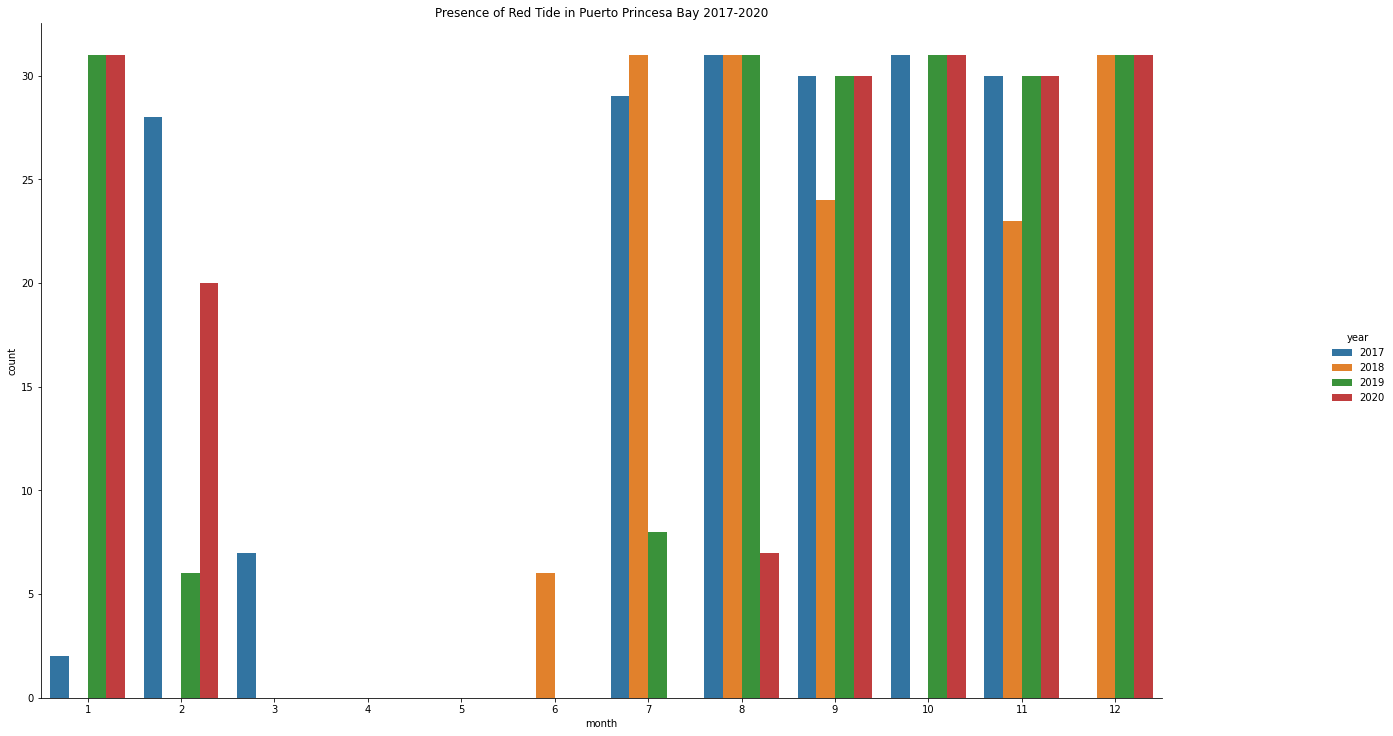

In [33]:
#Creating a bar graph that shows the red tide occurrences in Puerto Princesa Bay in the year 2020
barplot = sns.catplot(x = "month", kind = "count", hue="year", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['redtide_pp'] ==1)]).set(title='Presence of Red Tide in Puerto Princesa Bay 2017-2020')
barplot.fig.set_size_inches(20.5, 10.5)

Based on the bar graph, it can be observed that Puerto Princesa Bay is prone to red tides during the months of July to February from the years 2017 to 2020. 

### Bar Graph on the Presence of Red Tide in Honda Bay 2017-2020

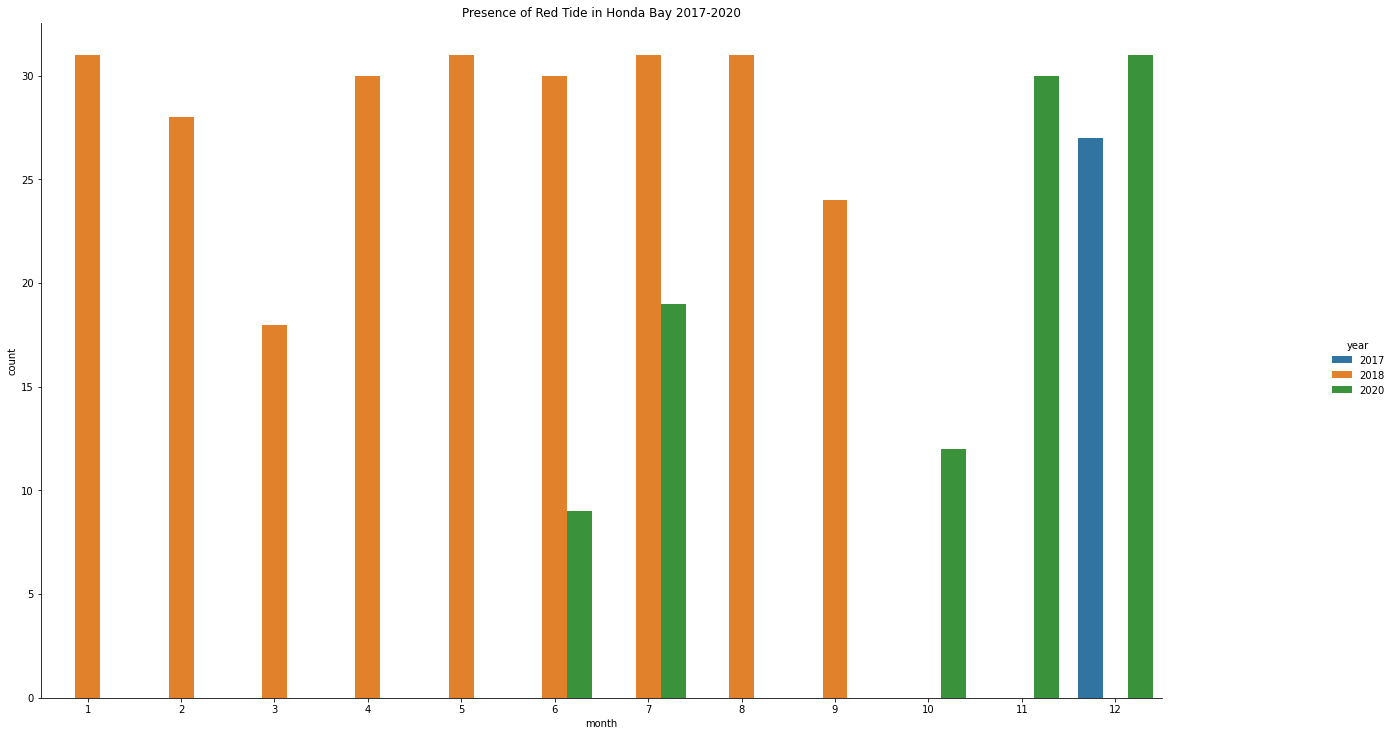

In [34]:
#Creating a bar graph that shows the red tide occurrences in Honda Bay in the year 2020
barplot = sns.catplot(x = "month", kind = "count", hue="year", order = [1,2,3,4,5,6,7,8,9,10,11,12], data = EDADF.loc[(EDADF['redtide_honda'] ==1)]).set(title='Presence of Red Tide in Honda Bay 2017-2020')
barplot.fig.set_size_inches(20.5, 10.5)

Based on the graph, it is observed that Honda Bay is prone to red tides on different months depending on the year. In the year 2018, Honda Bay is prone to red tide from Jaunary to September. While in 2019, there was no occurrences of red tide for the whole year.

## (Exploratory) Is there a pattern in the event of a red tide?

In [35]:
#Creating a dataframe for selected variables 
rtDF = finalDF[["date", "redtide_pp", "redtide_honda"]].copy()
rtDF["month"] = pd.DatetimeIndex(rtDF["date"]).month
rtDF

,date,redtide_pp,redtide_honda,month
0,2017-01-01,0,0,1
1,2017-01-02,0,0,1
2,2017-01-03,0,0,1
3,2017-01-04,0,0,1
4,2017-01-05,0,0,1
...,...,...,...,...
1456,2020-12-27,1,1,12
1457,2020-12-28,1,1,12
1458,2020-12-29,1,1,12
1459,2020-12-30,1,1,12


In [36]:
#Grouping the red tide occurrences in Puerto Princesa Bay by month from 2017-2020
total_rtpp_monthly = rtDF.groupby(["month"], as_index=False)["redtide_pp"].sum()
total_rtpp_monthly = total_rtpp_monthly.rename(columns={"month": "Month", "redtide_pp": "Red Tide Occurrences"}, errors="raise")
total_rtpp_monthly

,Month,Red Tide Occurrences
0,1,64
1,2,54
2,3,7
3,4,0
4,5,0
5,6,6
6,7,68
7,8,100
8,9,114
9,10,93


### Bar Graph on Red Tide Occurrences in Puerto Princesa Bay

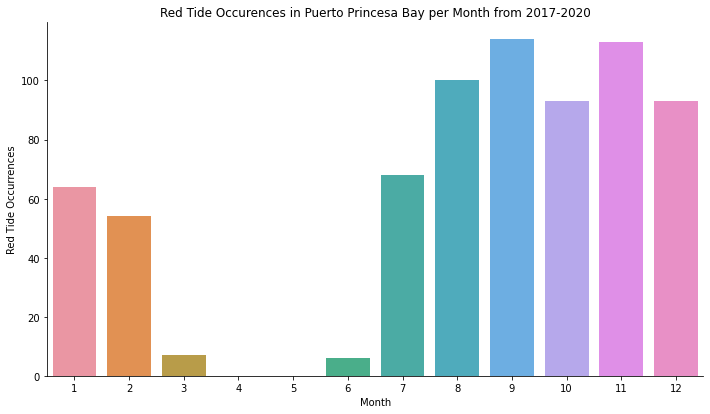

In [37]:
# Creating a bar graph on the red tide occurrences in Puerto Princesa Bay
total_annual_plot_pp = sns.catplot(data=total_rtpp_monthly, kind="bar", x="Month", y="Red Tide Occurrences").set(title='Red Tide Occurences in Puerto Princesa Bay per Month from 2017-2020')
total_annual_plot_pp.set_axis_labels("Month", "Red Tide Occurrences")
total_annual_plot_pp.fig.set_size_inches(10.5, 5.5)

### Calendar Heat Map on Red Tide Occurrences in Puerto Princesa Bay

(<Figure size 720x489.6 with 4 Axes>,
 array([<AxesSubplot:ylabel='2017'>, <AxesSubplot:ylabel='2018'>,
        <AxesSubplot:ylabel='2019'>, <AxesSubplot:ylabel='2020'>],
       dtype=object))

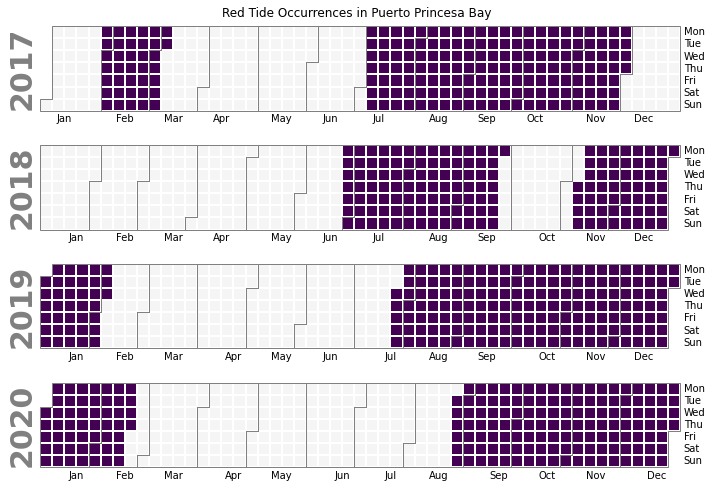

In [38]:
# Creating a calendar heat map on the red tide occurrences in Puerto Princesa Bay
data_pp = finalDF[["date", "redtide_pp"]] 
data_pp = data_pp.set_index("date")

calplot.calplot(data_pp["redtide_pp"], suptitle="Red Tide Occurrences in Puerto Princesa Bay", colorbar=False)

Similarly, as per the bar graph and calendar heatmap above, it could be said that the red tide occurrences in Puerto Princesa Bay often occur during the early months and the second half of the year. 

In [39]:
#Grouping the red tide occurrences in Honda Bay by month from 2017-2020
total_rthonda_monthly = rtDF.groupby(["month"], as_index=False)["redtide_honda"].sum()
total_rthonda_monthly = total_rthonda_monthly.rename(columns={"month": "Month", "redtide_honda": "Red Tide Occurrences"}, errors="raise")
total_rthonda_monthly

,Month,Red Tide Occurrences
0,1,31
1,2,28
2,3,18
3,4,30
4,5,31
5,6,39
6,7,50
7,8,31
8,9,24
9,10,12


### Bar Graph on Red Tide Occurrences in Honda Bay

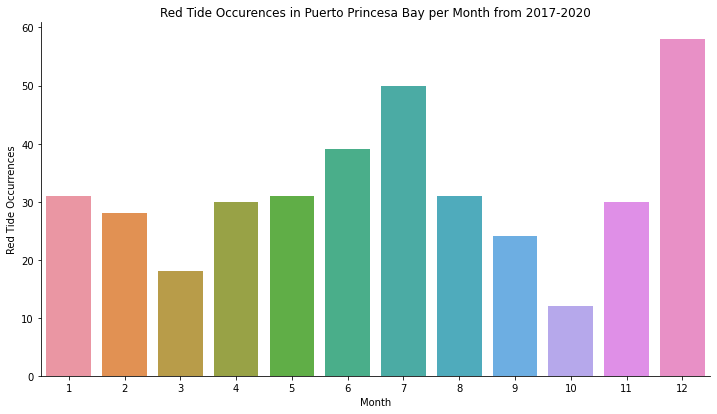

In [40]:
# Creating a bar graph on the red tide occurrences in Honda Bay
total_annual_plot_honda = sns.catplot(data=total_rthonda_monthly, kind="bar", x="Month", y="Red Tide Occurrences").set(title='Red Tide Occurences in Puerto Princesa Bay per Month from 2017-2020')
total_annual_plot_honda.set_axis_labels("Month", "Red Tide Occurrences")
total_annual_plot_honda.fig.set_size_inches(10.5, 5.5)

### Calendar Heat Map on Red Tide Occurrences in Honda Bay

(<Figure size 720x489.6 with 4 Axes>,
 array([<AxesSubplot:ylabel='2017'>, <AxesSubplot:ylabel='2018'>,
        <AxesSubplot:ylabel='2019'>, <AxesSubplot:ylabel='2020'>],
       dtype=object))

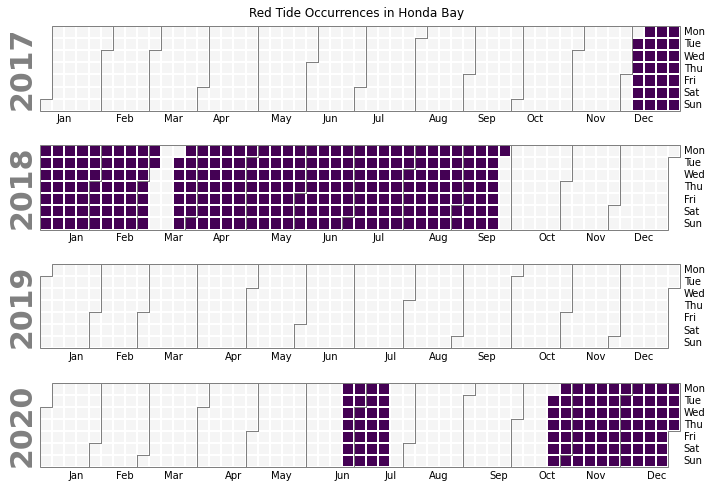

In [41]:
# Creating a calendar heatmap on the red tide occurrences in Honda Bay
data_honda = finalDF[["date", "redtide_honda"]] 
data_honda = data_honda.set_index("date")

calplot.calplot(data_honda["redtide_honda"], suptitle="Red Tide Occurrences in Honda Bay", colorbar=False)

Based on the bar graph and calendar heatmap, the red tide occurrences in Honda Bay has no pattern. It is notable though that in 2019, there was no reported red tide. Compared to the occurrences in Puerto Princesa Bay, the occurrences here are less frequent.

## (Exploratory) On average, what are the highest and lowest height of tides in a month? 

To get the highest and lowest heights of tides in a month, the high and low tide reading should be separated from each other and the tide height values should be in 1 column. Simply melting the tide height values would cause duplicate values because of the tidetype variable. Therefore, the data should be separated by the tide type first, and then by the tide height, and then now we can melt the tide height values.  

In [42]:
#Creates High Tide Height 1 dataframe to be able to isolate the 1st occurence of high tides in getting the averages.
th1DF = EDADF[["date", "tidetime1", "tideheight1", "tidetype1", "month", "year"]].copy()
hTH1DF = th1DF.loc[(th1DF['tidetype1'] == 1)]
hTH1DF

,date,tidetime1,tideheight1,tidetype1,month,year
2,2017-01-03,2017-01-03 00:20:00,1.3,1,1,2017
3,2017-01-04,2017-01-04 00:58:00,1.2,1,1,2017
4,2017-01-05,2017-01-05 01:40:00,1.1,1,1,2017
5,2017-01-06,2017-01-06 02:31:00,1.0,1,1,2017
6,2017-01-07,2017-01-07 03:47:00,0.8,1,1,2017
...,...,...,...,...,...,...
1449,2020-12-20,2020-12-20 00:50:00,1.5,1,12,2020
1450,2020-12-21,2020-12-21 01:35:00,1.3,1,12,2020
1451,2020-12-22,2020-12-22 02:23:00,1.2,1,12,2020
1452,2020-12-23,2020-12-23 03:17:00,1.0,1,12,2020


In [43]:
#Creates High Tide Height 2 dataframe to be able to isolate the 2nd occurence of high tides in getting the averages.
th2DF = EDADF[["date", "tidetime2", "tideheight2", "tidetype2", "month", "year"]]
hTH2DF = th2DF.loc[(th2DF['tidetype2'] == 1)]
hTH2DF

,date,tidetime2,tideheight2,tidetype2,month,year
0,2017-01-01,2017-01-01 23:44:00,1.4,1,1,2017
7,2017-01-08,2017-01-08 06:03:00,0.6,1,1,2017
8,2017-01-09,2017-01-09 08:34:00,0.6,1,1,2017
9,2017-01-10,2017-01-10 20:05:00,1.4,1,1,2017
10,2017-01-11,2017-01-11 20:50:00,1.5,1,1,2017
...,...,...,...,...,...,...
1456,2020-12-27,2020-12-27 10:10:00,0.6,1,12,2020
1457,2020-12-28,2020-12-28 20:51:00,1.3,1,12,2020
1458,2020-12-29,2020-12-29 21:24:00,1.4,1,12,2020
1459,2020-12-30,2020-12-30 21:59:00,1.4,1,12,2020


In [44]:
#Creates High Tide Height 3 dataframe to be able to isolate the 3rd occurence of high tides in getting the averages.
th3DF = EDADF[["date", "tidetime3", "tideheight3", "tidetype3", "month", "year"]]
hTH3DF = th3DF.loc[(th3DF['tidetype3'] == 1)]
hTH3DF

,date,tidetime3,tideheight3,tidetype3,month,year
4,2017-01-05,2017-01-05 17:30:00,0.7,1,1,2017
5,2017-01-06,2017-01-06 17:44:00,0.8,1,1,2017
6,2017-01-07,2017-01-07 18:09:00,1.0,1,1,2017
16,2017-01-17,2017-01-17 15:26:00,0.6,1,1,2017
17,2017-01-18,2017-01-18 15:57:00,0.7,1,1,2017
...,...,...,...,...,...,...
1424,2020-11-25,2020-11-25 20:33:00,0.9,1,11,2020
1438,2020-12-09,2020-12-09 20:03:00,0.8,1,12,2020
1439,2020-12-10,2020-12-10 19:42:00,0.9,1,12,2020
1452,2020-12-23,2020-12-23 19:17:00,0.8,1,12,2020


In [45]:
#Creates High Tide Height 4 dataframe to be able to isolate the 4th occurence of high tides in getting the averages.
th4DF = EDADF[["date", "tidetime4", "tideheight4", "tidetype4", "month", "year"]]
hTH4DF = th4DF.loc[(th4DF['tidetype4'] == 1)]
hTH4DF

,date,tidetime4,tideheight4,tidetype4,month,year
7,2017-01-08,2017-01-08 18:43:00,1.1,1,1,2017
8,2017-01-09,2017-01-09 19:22:00,1.3,1,1,2017
14,2017-01-15,2017-01-15 23:51:00,1.4,1,1,2017
21,2017-01-22,2017-01-22 18:24:00,1.0,1,1,2017
22,2017-01-23,2017-01-23 19:06:00,1.1,1,1,2017
...,...,...,...,...,...,...
1441,2020-12-12,2020-12-12 20:11:00,1.3,1,12,2020
1442,2020-12-13,2020-12-13 20:41:00,1.4,1,12,2020
1454,2020-12-25,2020-12-25 19:32:00,1.0,1,12,2020
1455,2020-12-26,2020-12-26 19:54:00,1.1,1,12,2020


In [46]:
#Concatenate high tides dataframe 1 and 2
hTH12DF = hTH1DF.append(hTH2DF)
hTH12DF

,date,tidetime1,tideheight1,tidetype1,month,year,tidetime2,tideheight2,tidetype2
2,2017-01-03,2017-01-03 00:20:00,1.3,1,1,2017,NaT,NaN,NaN
3,2017-01-04,2017-01-04 00:58:00,1.2,1,1,2017,NaT,NaN,NaN
4,2017-01-05,2017-01-05 01:40:00,1.1,1,1,2017,NaT,NaN,NaN
5,2017-01-06,2017-01-06 02:31:00,1.0,1,1,2017,NaT,NaN,NaN
6,2017-01-07,2017-01-07 03:47:00,0.8,1,1,2017,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1456,2020-12-27,NaT,NaN,NaN,12,2020,2020-12-27 10:10:00,0.6,1
1457,2020-12-28,NaT,NaN,NaN,12,2020,2020-12-28 20:51:00,1.3,1
1458,2020-12-29,NaT,NaN,NaN,12,2020,2020-12-29 21:24:00,1.4,1
1459,2020-12-30,NaT,NaN,NaN,12,2020,2020-12-30 21:59:00,1.4,1


In [47]:
#Merges tideheight1 and tideheight2 columns
hTH12meltDF = hTH12DF.melt(id_vars=["date", "month", "year"], value_vars=["tideheight1", "tideheight2"], var_name="tideheight",value_name = "tideheightvalue")
hTH12meltDF.sort_values(by=['date'], inplace=True)
hTH12meltDF

,date,month,year,tideheight,tideheightvalue
2246,2017-01-01,1,2017,tideheight2,1.4
809,2017-01-01,1,2017,tideheight1,NaN
0,2017-01-03,1,2017,tideheight1,1.3
1437,2017-01-03,1,2017,tideheight2,NaN
1,2017-01-04,1,2017,tideheight1,1.2
...,...,...,...,...,...
1434,2020-12-29,12,2020,tideheight1,NaN
2872,2020-12-30,12,2020,tideheight2,1.4
1435,2020-12-30,12,2020,tideheight1,NaN
1436,2020-12-31,12,2020,tideheight1,NaN


In [48]:
#Concatenate high tides dataframe 3 and 4
hTH34DF = hTH3DF.append(hTH4DF)
hTH34DF

,date,tidetime3,tideheight3,tidetype3,month,year,tidetime4,tideheight4,tidetype4
4,2017-01-05,2017-01-05 17:30:00,0.7,1,1,2017,NaT,NaN,NaN
5,2017-01-06,2017-01-06 17:44:00,0.8,1,1,2017,NaT,NaN,NaN
6,2017-01-07,2017-01-07 18:09:00,1.0,1,1,2017,NaT,NaN,NaN
16,2017-01-17,2017-01-17 15:26:00,0.6,1,1,2017,NaT,NaN,NaN
17,2017-01-18,2017-01-18 15:57:00,0.7,1,1,2017,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1441,2020-12-12,NaT,NaN,NaN,12,2020,2020-12-12 20:11:00,1.3,1
1442,2020-12-13,NaT,NaN,NaN,12,2020,2020-12-13 20:41:00,1.4,1
1454,2020-12-25,NaT,NaN,NaN,12,2020,2020-12-25 19:32:00,1.0,1
1455,2020-12-26,NaT,NaN,NaN,12,2020,2020-12-26 19:54:00,1.1,1


In [49]:
#Merges tideheight3 and tideheight4 columns
hTH34meltDF = hTH34DF.melt(id_vars=["date", "month", "year"], value_vars=["tideheight3", "tideheight4"], var_name="tideheight",value_name = "tideheightvalue")
hTH34meltDF.sort_values(by=['date'], inplace=True)
hTH34meltDF

,date,month,year,tideheight,tideheightvalue
0,2017-01-05,1,2017,tideheight3,0.7
750,2017-01-05,1,2017,tideheight4,NaN
1,2017-01-06,1,2017,tideheight3,0.8
751,2017-01-06,1,2017,tideheight4,NaN
2,2017-01-07,1,2017,tideheight3,1.0
...,...,...,...,...,...
747,2020-12-25,12,2020,tideheight3,NaN
1498,2020-12-26,12,2020,tideheight4,1.1
748,2020-12-26,12,2020,tideheight3,NaN
749,2020-12-27,12,2020,tideheight3,NaN


In [50]:
#Concatenates both merged dataframes
hTHDF = hTH12meltDF.append(hTH34meltDF)
hTHDF

,date,month,year,tideheight,tideheightvalue
2246,2017-01-01,1,2017,tideheight2,1.4
809,2017-01-01,1,2017,tideheight1,NaN
0,2017-01-03,1,2017,tideheight1,1.3
1437,2017-01-03,1,2017,tideheight2,NaN
1,2017-01-04,1,2017,tideheight1,1.2
...,...,...,...,...,...
747,2020-12-25,12,2020,tideheight3,NaN
1498,2020-12-26,12,2020,tideheight4,1.1
748,2020-12-26,12,2020,tideheight3,NaN
749,2020-12-27,12,2020,tideheight3,NaN


### Box Plot on the High Tide Heights from 2017-2020

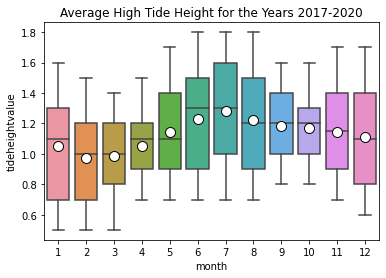

In [51]:
#Creating a box and whisker plot on the average high tide height from 2017-2020
whisk = sns.boxplot(x = "month", y = 'tideheightvalue' , order = [1,2,3,4,5,6,7,8,9,10,11,12], data = hTHDF, showmeans = True, 
meanprops={"marker":"o",
           "markerfacecolor":"white", 
           "markeredgecolor":"black",
           "markersize":"10"}).set(title='Average High Tide Height for the Years 2017-2020')

From the graph above, it can be observed that the avreage High Tide Height from the Years 2017-2020 range approximately from 1.0 to 1.3.

Similarly, we will be repeating the same process as done for the high tides.

In [52]:
#Low tide heights
lTH1DF = th1DF.loc[(th1DF['tidetype1'] == -1)]
lTH2DF = th2DF.loc[(th2DF['tidetype2'] == -1)]
lTH3DF = th3DF.loc[(th3DF['tidetype3'] == -1)]
lTH4DF = th4DF.loc[(th4DF['tidetype4'] == -1)]

lTH1DF
#lTH2DF
#lTH3DF
#lTH4DF

,date,tidetime1,tideheight1,tidetype1,month,year
0,2017-01-01,2017-01-01 07:44:00,-0.2,-1,1,2017
1,2017-01-02,2017-01-02 08:12:00,-0.2,-1,1,2017
7,2017-01-08,2017-01-08 01:05:00,0.2,-1,1,2017
8,2017-01-09,2017-01-09 02:40:00,0.1,-1,1,2017
9,2017-01-10,2017-01-10 03:42:00,-0.1,-1,1,2017
...,...,...,...,...,...,...
1456,2020-12-27,2020-12-27 03:51:00,0.0,-1,12,2020
1457,2020-12-28,2020-12-28 04:34:00,-0.1,-1,12,2020
1458,2020-12-29,2020-12-29 05:14:00,-0.2,-1,12,2020
1459,2020-12-30,2020-12-30 05:54:00,-0.2,-1,12,2020


In [53]:
#Concatenate low tides dataframe 1 and 2, and low tides dataframe 3 and 4, respectively.
lTH12DF = lTH1DF.append(lTH2DF)
lTH34DF = lTH3DF.append(lTH4DF)

lTH12DF
#lTH34DF

,date,tidetime1,tideheight1,tidetype1,month,year,tidetime2,tideheight2,tidetype2
0,2017-01-01,2017-01-01 07:44:00,-0.2,-1,1,2017,NaT,NaN,NaN
1,2017-01-02,2017-01-02 08:12:00,-0.2,-1,1,2017,NaT,NaN,NaN
7,2017-01-08,2017-01-08 01:05:00,0.2,-1,1,2017,NaT,NaN,NaN
8,2017-01-09,2017-01-09 02:40:00,0.1,-1,1,2017,NaT,NaN,NaN
9,2017-01-10,2017-01-10 03:42:00,-0.1,-1,1,2017,NaT,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1449,2020-12-20,NaT,NaN,NaN,12,2020,2020-12-20 09:51:00,-0.2,-1
1450,2020-12-21,NaT,NaN,NaN,12,2020,2020-12-21 10:32:00,-0.1,-1
1451,2020-12-22,NaT,NaN,NaN,12,2020,2020-12-22 11:06:00,0.0,-1
1452,2020-12-23,NaT,NaN,NaN,12,2020,2020-12-23 11:33:00,0.1,-1


In [54]:
#Merges tideheight1 and tideheight2 columns
lTH12meltDF = lTH12DF.melt(id_vars=["date", "month", "year"], value_vars=["tideheight1", "tideheight2"], var_name="tideheight",value_name = "tideheightvalue")
lTH12meltDF.sort_values(by=['date'], inplace=True)
lTH12meltDF

,date,month,year,tideheight,tideheightvalue
0,2017-01-01,1,2017,tideheight1,-0.2
1435,2017-01-01,1,2017,tideheight2,NaN
1,2017-01-02,1,2017,tideheight1,-0.2
1436,2017-01-02,1,2017,tideheight2,NaN
2087,2017-01-03,1,2017,tideheight2,-0.2
...,...,...,...,...,...
649,2020-12-29,12,2020,tideheight1,-0.2
2085,2020-12-30,12,2020,tideheight2,NaN
650,2020-12-30,12,2020,tideheight1,-0.2
651,2020-12-31,12,2020,tideheight1,-0.3


In [55]:
#Merges tideheight3 and tideheight4 columns
lTH34meltDF = lTH34DF.melt(id_vars=["date", "month", "year"], value_vars=["tideheight3", "tideheight4"], var_name="tideheight",value_name = "tideheightvalue")
lTH34meltDF.sort_values(by=['date'], inplace=True)
lTH34meltDF

,date,month,year,tideheight,tideheightvalue
434,2017-01-05,1,2017,tideheight3,NaN
1186,2017-01-05,1,2017,tideheight4,0.4
435,2017-01-06,1,2017,tideheight3,NaN
1187,2017-01-06,1,2017,tideheight4,0.4
0,2017-01-08,1,2017,tideheight3,0.2
...,...,...,...,...,...
431,2020-12-25,12,2020,tideheight3,0.2
1184,2020-12-26,12,2020,tideheight4,NaN
432,2020-12-26,12,2020,tideheight3,0.3
433,2020-12-27,12,2020,tideheight3,0.3


In [56]:
#Concatenates both merged dataframes
lTHDF = lTH12meltDF.append(lTH34meltDF)
lTHDF

,date,month,year,tideheight,tideheightvalue
0,2017-01-01,1,2017,tideheight1,-0.2
1435,2017-01-01,1,2017,tideheight2,NaN
1,2017-01-02,1,2017,tideheight1,-0.2
1436,2017-01-02,1,2017,tideheight2,NaN
2087,2017-01-03,1,2017,tideheight2,-0.2
...,...,...,...,...,...
431,2020-12-25,12,2020,tideheight3,0.2
1184,2020-12-26,12,2020,tideheight4,NaN
432,2020-12-26,12,2020,tideheight3,0.3
433,2020-12-27,12,2020,tideheight3,0.3


### Box Plot for the Low Tide Heights from 2017-2020

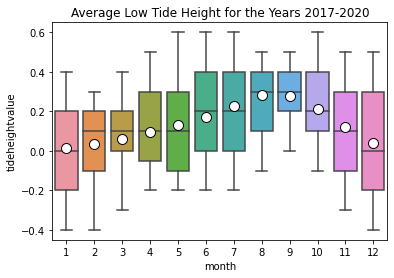

In [57]:
#Creating a box and whisker plot on the average low tide height from 2017-2020
whisk = sns.boxplot(x = "month", y = 'tideheightvalue' , order = [1,2,3,4,5,6,7,8,9,10,11,12], data = lTHDF, showmeans = True, 
meanprops={"marker":"o",
           "markerfacecolor":"white", 
           "markeredgecolor":"black",
           "markersize":"10"}).set(title='Average Low Tide Height for the Years 2017-2020')

From the graph above, it can be observed that the avreage Low Tide Height from the Years 2017-2020 range approximately from 0.0 to 0.3.

## (Exploratory) On average, what times do low or high tides happen? and (Inferential) What time of the day and/or day of the month and/or month of the year would be best for recreational activities? 

Several rearrangements and transformations to the data were needed to be done to be able to group together months and time of the occurrences of high and low tides. These transformations were also done to simplify the aggregation of the occurrences of high and low tides to be able to form a heatmap that will show the pattern of these occurrences.

In [58]:
# Create a copy of the final data frame to not mess with the original dataset.
AverageLH = finalDF.copy()
# Only get the month of the date.
AverageLH['date'] = AverageLH['date'].dt.month
# Copies the tide information and date into Tides dataframe.
Tides = AverageLH[['date','tidetime1','tidetype1', 'tidetime2','tidetype2','tidetime3','tidetype3','tidetime4','tidetype4']].copy()

# for index, row in AveLH.iterrows():
#     if isinstance(row['tidetime1'], datetime.datetime):
#         toRep= row['tidetime1']
#         rep= row['tidetime1'].hour
#         print(toRep)
#         AveLH.replace({'tidetime1': {'2017-01-01 07:44:00' : rep}})
#         print(AverageLH['tidetime1'])
#         row['tidetime1']= row['tidetime1'].hour
#         AverageLH['tidetieprint(row['tidetime1'])

#Form arrays for each tide occurence to transform the tide time columns that will represent the hour that the tide occurrence happened.
tidesarray1 = []
tidesarray2 = []
tidesarray3 = []
tidesarray4 = []

for index, row in Tides.iterrows():
    if isinstance(row['tidetime1'], datetime.datetime):
        row['tidetime1']= row['tidetime1'].hour
        tidesarray1.append(row['tidetime1'])
        
    if isinstance(row['tidetime2'], datetime.datetime):
        row['tidetime2']= row['tidetime2'].hour
        tidesarray2.append(row['tidetime2'])
    else:
        tidesarray2.append(9999)
        
    if isinstance(row['tidetime3'], datetime.datetime):
        row['tidetime3']= row['tidetime3'].hour
        tidesarray3.append(row['tidetime3'])
    else:
        tidesarray3.append(9999)
        
    if isinstance(row['tidetime4'], datetime.datetime):
        row['tidetime4']= row['tidetime4'].hour
        tidesarray4.append(row['tidetime4'])
    else:
        tidesarray4.append(9999)
        
#Tides array
Tides['tidetime1']=tidesarray1
Tides['tidetime2']=tidesarray2
Tides['tidetime3']=tidesarray3
Tides['tidetime4']=tidesarray4
Tides

,date,tidetime1,tidetype1,tidetime2,tidetype2,tidetime3,tidetype3,tidetime4,tidetype4
0,1,7,-1,23.0,1,NaN,0,NaN,0
1,1,8,-1,NaN,0,NaN,0,NaN,0
2,1,0,1,8.0,-1,NaN,0,NaN,0
3,1,0,1,9.0,-1,NaN,0,NaN,0
4,1,1,1,9.0,-1,17.0,1,20.0,-1
...,...,...,...,...,...,...,...,...,...
1456,12,3,-1,10.0,1,12.0,-1,20.0,1
1457,12,4,-1,20.0,1,NaN,0,NaN,0
1458,12,5,-1,21.0,1,NaN,0,NaN,0
1459,12,5,-1,21.0,1,NaN,0,NaN,0


In [59]:
# Renames `date` column to `month` as it has already been transformed to only represent the month of the entry
AverageLH = Tides.rename(columns={"date":"Month"})

In [60]:
# Copies AverageLH into tideA which will take in the feature generations needed for high tide.
tideA = AverageLH.copy()
tideA

,Month,tidetime1,tidetype1,tidetime2,tidetype2,tidetime3,tidetype3,tidetime4,tidetype4
0,1,7,-1,23.0,1,NaN,0,NaN,0
1,1,8,-1,NaN,0,NaN,0,NaN,0
2,1,0,1,8.0,-1,NaN,0,NaN,0
3,1,0,1,9.0,-1,NaN,0,NaN,0
4,1,1,1,9.0,-1,17.0,1,20.0,-1
...,...,...,...,...,...,...,...,...,...
1456,12,3,-1,10.0,1,12.0,-1,20.0,1
1457,12,4,-1,20.0,1,NaN,0,NaN,0
1458,12,5,-1,21.0,1,NaN,0,NaN,0
1459,12,5,-1,21.0,1,NaN,0,NaN,0


In [61]:
# Transforming the high tide occurrences into a binary format 0 and 1 where 0 denotes not high tide and 1 denotes high tide.
# This will be helpful in forming the heatmap as it will be easier to aggregate and get the count of occurrences.

#For high tides
hightype1 = []
hightype2 = []
hightype3 = []
hightype4 = []

hightime2 = []
hightime3 = []
hightime4 = []

for index, row in tideA.iterrows():
    if row['tidetype1'] == -1 or row['tidetype1'] == 0:
        change = 0
        hightype1.append(0)
    elif row['tidetype1'] == 1:
        hightype1.append(1)
    
for index, row in tideA.iterrows():
    if row['tidetype2'] == -1 or row['tidetype2'] == 0:
        hightype2.append(0)
    elif row['tidetype2'] == 1:
        hightype2.append(1)

    if pd.isna(row['tidetime2']):
        hightime2.append(0)
    else:
        hightime2.append(row['tidetime2'])

for index, row in tideA.iterrows():
    if row['tidetype3'] == -1 or row['tidetype3'] == 0:
        hightype3.append(0)
    elif row['tidetype3'] == 1:
        hightype3.append(1)
    
    if pd.isna(row['tidetime3']):
        hightime3.append(0)
    else:
        hightime3.append(row['tidetime3'])
        
for index, row in tideA.iterrows():
    if row['tidetype4'] == -1 or row['tidetype4'] == 0:
        hightype4.append(0)
    elif row['tidetype4'] == 1:
        hightype4.append(1)
    else:
#         print(row['tidetype4'])
        hightype4.append(0)
        
    if pd.isna(row['tidetime4']):
        hightime4.append(0)
    else:
        hightime4.append(row['tidetime4'])


#Assign High    
tideA['tidetype1'] = hightype1
tideA['tidetype2'] = hightype2
tideA['tidetype3'] = hightype3
tideA['tidetype4'] = hightype4

tideA['tidetime2'] = hightime2
tideA['tidetime3'] = hightime3
tideA['tidetime4'] = hightime4

tide1 = tideA[['Month','tidetime1','tidetype1']]
tide2 = tideA[['Month', 'tidetime2','tidetype2']]
tide3 = tideA[['Month', 'tidetime3','tidetype3']]
tide4 = tideA[['Month', 'tidetime4','tidetype4']]

In [62]:
# Copies AverageLH and renames the tide information with low into tideB which will take in the feature generations/transformations needed for low tides.
tideB = AverageLH.copy()
tideB = tideB.rename(columns={"tidetype1":"lowtidetype1", "tidetime1":"lowtidetime1","tidetype2":"lowtidetype2", "tidetime2":"lowtidetime2",
                              "tidetype3":"lowtidetype3", "tidetime3":"lowtidetime3","tidetype4":"lowtidetype4", "tidetime4":"lowtidetime4"})
tideB

,Month,lowtidetime1,lowtidetype1,lowtidetime2,lowtidetype2,lowtidetime3,lowtidetype3,lowtidetime4,lowtidetype4
0,1,7,-1,23.0,1,NaN,0,NaN,0
1,1,8,-1,NaN,0,NaN,0,NaN,0
2,1,0,1,8.0,-1,NaN,0,NaN,0
3,1,0,1,9.0,-1,NaN,0,NaN,0
4,1,1,1,9.0,-1,17.0,1,20.0,-1
...,...,...,...,...,...,...,...,...,...
1456,12,3,-1,10.0,1,12.0,-1,20.0,1
1457,12,4,-1,20.0,1,NaN,0,NaN,0
1458,12,5,-1,21.0,1,NaN,0,NaN,0
1459,12,5,-1,21.0,1,NaN,0,NaN,0


In [63]:
# Transforming the low tide occurrences into a binary format 0 and 1 where 0 denotes not low tide and 1 denotes low tide.
# This will be helpful in forming the heatmap as it will be easier to aggregate and get the count of occurrences.

#For low tides
lowtype1 = []
lowtype2 = []
lowtype3 = []
lowtype4 = []

lowtime2 = []
lowtime3 = []
lowtime4 = []

for index, row in tideB.iterrows():
    if row['lowtidetype1'] == 1 or row['lowtidetype1'] == 0:
        lowtype1.append(0)
    elif row['lowtidetype1'] == -1:
        lowtype1.append(1)
    
for index, row in tideB.iterrows():
    if row['lowtidetype2'] == 1 or row['lowtidetype2'] == 0:
        lowtype2.append(0)
    elif row['lowtidetype2'] == -1:
        lowtype2.append(1)
    
    if pd.isna(row['lowtidetime2']):
        lowtime2.append(0)
    else:
        lowtime2.append(row['lowtidetime2'])

        
for index, row in tideB.iterrows():
    if row['lowtidetype3'] == 1 or row['lowtidetype3'] == 0:
        lowtype3.append(0)
    elif row['lowtidetype3'] == -1:
        lowtype3.append(1)
    
    if pd.isna(row['lowtidetime3']):
        lowtime3.append(0)
    else:
        lowtime3.append(row['lowtidetime3'])
        
for index, row in tideB.iterrows():
    if row['lowtidetype4'] == 1 or row['lowtidetype4'] == 0:
        lowtype4.append(0)
    elif row['lowtidetype4'] == -1:
        lowtype4.append(1)
    else:
#         print(row['lowtidetype4'])
        lowtype4.append(0)
        
    if pd.isna(row['lowtidetime4']):
        lowtime4.append(0)
    else:
        lowtime4.append(row['lowtidetime4'])

#Assign low
tideB['lowtidetype1'] = lowtype1
tideB['lowtidetype2'] = lowtype2
tideB['lowtidetype3'] = lowtype3
tideB['lowtidetype4'] = lowtype4

#print(tideB['lowtidetype1'])
#print(lowtype1)
tideB['lowtidetime2'] = lowtime2
tideB['lowtidetime3'] = lowtime3
tideB['lowtidetime4'] = lowtime4


Ltide1 = tideB[['Month','lowtidetime1','lowtidetype1']]
Ltide2 = tideB[['Month','lowtidetime2','lowtidetype2']]
Ltide3 = tideB[['Month','lowtidetime3','lowtidetype3']]
Ltide4 = tideB[['Month','lowtidetime4','lowtidetype4']]

The following code will be forming and forming the matrices that will be used in the heatmap.

In [64]:
#For High
tide1matrix = pd.pivot_table(tide1, index='Month', columns='tidetime1', values='tidetype1', aggfunc=np.sum, fill_value=0)
tide2matrix = pd.pivot_table(tide2, index='Month', columns='tidetime2', values='tidetype2', aggfunc=np.sum, fill_value=0)
tide3matrix = pd.pivot_table(tide3, index='Month', columns='tidetime3', values='tidetype3', aggfunc=np.sum, fill_value=0)
tide4matrix = pd.pivot_table(tide4, index='Month', columns='tidetime4', values='tidetype4', aggfunc=np.sum, fill_value=0)

#For Low
Ltide1matrix = pd.pivot_table(Ltide1, index='Month', columns='lowtidetime1', values='lowtidetype1', aggfunc=np.sum, fill_value=0)
Ltide2matrix = pd.pivot_table(Ltide2, index='Month', columns='lowtidetime2', values='lowtidetype2', aggfunc=np.sum, fill_value=0)
Ltide3matrix = pd.pivot_table(Ltide3, index='Month', columns='lowtidetime3', values='lowtidetype3', aggfunc=np.sum, fill_value=0)
Ltide4matrix = pd.pivot_table(Ltide4, index='Month', columns='lowtidetime4', values='lowtidetype4', aggfunc=np.sum, fill_value=0)
#c=pd.concat([tide1matrix, tide2matrix], axis = 1)
#tide1matrix
add=[0,0,0,0,0,0,0,0,0,0,0,0]

#For HTIDE
tide1matrix.insert(17, "17", add)
tide1matrix.insert(18, "18", add)
tide1matrix.insert(19, "19", add)
tide1matrix.insert(20, "20", add)
tide1matrix.insert(21, "21", add)
tide1matrix.insert(22, "22", add)
tide1matrix.insert(23, "23", add)

tide3matrix.insert(1,"1.0",add)
tide3matrix.insert(2,"2.0",add)
tide3matrix.insert(3,"3.0",add)
tide3matrix.insert(4,"4.0",add)
tide3matrix.insert(5,"5.0",add)
tide3matrix.insert(6,"6.0",add)
tide3matrix.insert(7,"7.0",add)

tide4matrix.insert(1,"1.0",add)
tide4matrix.insert(2,"2.0",add)
tide4matrix.insert(3,"3.0",add)
tide4matrix.insert(4,"4.0",add)
tide4matrix.insert(5,"5.0",add)
tide4matrix.insert(6,"6.0",add)
tide4matrix.insert(7,"7.0",add)
tide4matrix.insert(8,"8.0",add)
tide4matrix.insert(9,"9.0",add)
tide4matrix.insert(10,"10.0",add)
tide4matrix.insert(11,"11.0",add)
tide4matrix.insert(12,"12.0",add)
tide4matrix.insert(13,"13.0",add)
tide4matrix.insert(14,"14.0",add)
tide4matrix.insert(15,"15.0",add)

firstadd = np.add(tide1matrix,tide2matrix)
secondadd = np.add(firstadd, tide3matrix)
finalhighmatrix = np.add(secondadd,tide4matrix)

#For LTIDE

<ipython-input-64-9a1be1200319>:49: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  firstadd = np.add(tide1matrix,tide2matrix)
<ipython-input-64-9a1be1200319>:50: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the cu

In [65]:
Ltide1matrix.insert(17, "17", add)
Ltide1matrix.insert(18, "18", add)
Ltide1matrix.insert(19, "19", add)
Ltide1matrix.insert(20, "20", add)
Ltide1matrix.insert(21, "21", add)
Ltide1matrix.insert(22, "22", add)
Ltide1matrix.insert(23, "23", add)

In [66]:
Ltide3matrix.insert(1,"1.0",add)
Ltide3matrix.insert(2,"2.0",add)
Ltide3matrix.insert(3,"3.0",add)
Ltide3matrix.insert(4,"4.0",add)
Ltide3matrix.insert(5,"5.0",add)
Ltide3matrix.insert(6,"6.0",add)
Ltide3matrix.insert(7,"7.0",add)

In [67]:
Ltide4matrix.insert(1,"1.0",add)
Ltide4matrix.insert(2,"2.0",add)
Ltide4matrix.insert(3,"3.0",add)
Ltide4matrix.insert(4,"4.0",add)
Ltide4matrix.insert(5,"5.0",add)
Ltide4matrix.insert(6,"6.0",add)
Ltide4matrix.insert(7,"7.0",add)
Ltide4matrix.insert(8,"8.0",add)
Ltide4matrix.insert(9,"9.0",add)
Ltide4matrix.insert(10,"10.0",add)
Ltide4matrix.insert(11,"11.0",add)
Ltide4matrix.insert(12,"12.0",add)
Ltide4matrix.insert(13,"13.0",add)
Ltide4matrix.insert(14,"14.0",add)
Ltide4matrix.insert(15,"15.0",add)

Lfirstadd = np.add(Ltide1matrix,Ltide2matrix)
Lsecondadd = np.add(Lfirstadd, Ltide3matrix)
finallowmatrix = np.add(Lsecondadd,Ltide4matrix)
finallowmatrix

<ipython-input-67-82e8ea59f066>:17: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  Lfirstadd = np.add(Ltide1matrix,Ltide2matrix)
<ipython-input-67-82e8ea59f066>:18: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the

lowtidetime1,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Month,,,,,,,,,,,,,,,,,,,,,
1,3,6,6,10,14,9,14,15,15,22,...,1,5,3,4,3,5,2,5,3,4
2,3,6,5,11,10,13,14,25,22,7,...,5,8,8,7,6,6,5,6,3,5
3,3,6,11,9,19,21,29,13,0,0,...,8,10,8,9,8,8,8,5,6,7
4,8,9,11,19,28,19,2,0,0,0,...,5,9,9,10,9,9,9,6,6,6
5,11,15,28,19,4,0,0,0,0,0,...,9,9,9,9,12,9,8,10,9,10
6,24,13,5,0,0,0,1,0,1,3,...,3,9,12,10,12,10,11,11,13,16
7,2,0,1,2,1,2,3,5,3,4,...,8,10,11,14,11,15,14,20,21,10
8,1,1,7,9,8,9,7,5,6,4,...,8,9,16,13,17,22,24,10,0,0
9,4,7,6,10,8,8,8,7,7,7,...,10,9,17,22,28,11,0,0,0,1


### Heat Map for High Tides

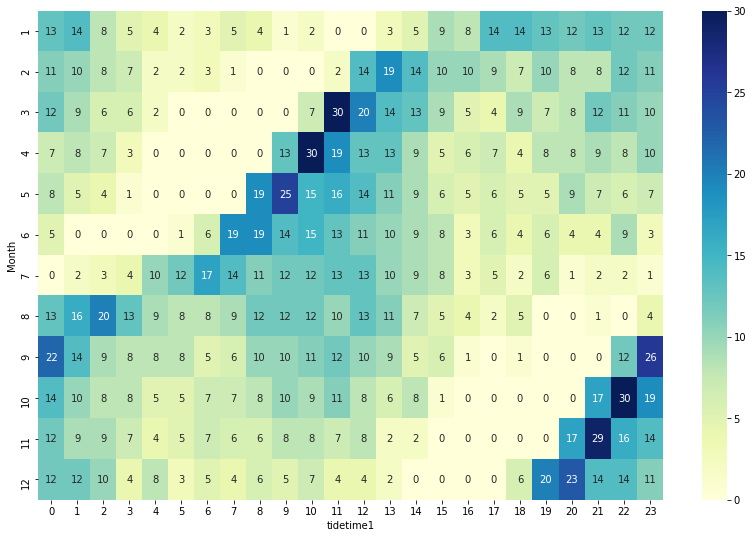

In [68]:
#This heat map also answers the question above (Question B)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14,9))
Htideheatmap = sns.heatmap(finalhighmatrix, cmap="YlGnBu", annot=True, fmt="d", annot_kws={"size": 10}, ax=ax)

#tide1heatmap

From the Heat Map, it can be observed that the occurence of high tide arrives earlier with each passing month. Moreover, the best time for recreational activites would be from noon to the late afternoon during the first half of the year, then midnight to early morning during the second half of the year.

### Heat Map for Low Tides

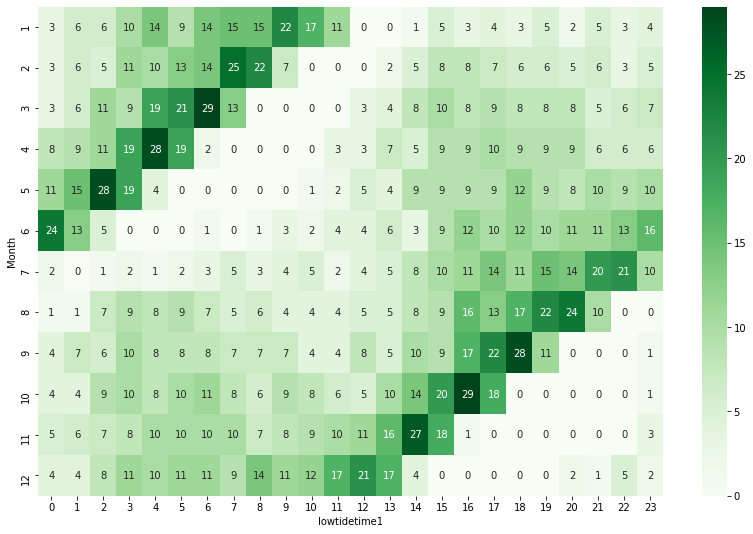

In [69]:
fig, ax = plt.subplots(figsize=(14,9))
Ltideheatmap = sns.heatmap(finallowmatrix, cmap="Greens",annot=True, fmt="d", annot_kws={"size": 10}, ax=ax)

From the heatmap, it can be observed that as the months go, the occurrence of low tides readings becomes earlier. Starting from late mornings during the first month, then midnight, then to early afternoon's nearing the end of the year.